# Spring lattice sketch


## Imports


In [1]:

# from typing import NamedTuple, Optional, Callable, Dict, Any, Tuple, List, Union
# from dataclasses import dataclass
import scipy.io
# import jax.numpy as jnp
import pandas as pd
# from jax import grad, vmap, jacobian
# from jax.experimental.ode import odeint
# from jax._src.config import config
# config.update("jax_enable_x64", True)  # enable float64 type

# %matplotlib widget
# plt.style.use(["science", "grid"])

from morphing_lattices.plotting import plot_lattice
from morphing_lattices.structure import ControlParams, Lattice
from morphing_lattices.dynamics import setup_dynamic_solver
from morphing_lattices.geometry import triangular_lattice_connectivity, triangular_lattice_points
from morphing_lattices.kinematics import build_strain_fn
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type

%matplotlib widget
plt.style.use(["science", "grid"])



No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Thermally responsive mass-spring lattice


### Import experimental data

In [10]:
exp_actuation_strain = pd.read_csv('../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv').drop(['Unnamed: 3'], axis=1)
exp_modulus_stress = pd.read_csv('../exp/mechanical_data/LTNI and HTNI LCE strains and moduli from Arda.csv')
exp_modulus_stress.drop(exp_modulus_stress.columns[[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, -1]], axis=1, inplace=True)
exp_modulus_stress.columns = exp_modulus_stress.iloc[0]
exp_modulus_stress.drop(0, inplace=True)

HTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG HTNI', 'STD HTNI']].astype(float)
LTNI_stretch_data = exp_actuation_strain[['temp [C]', 'AVG LTNI', 'STD LTNI']].astype(float)

HTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to HTNI data', 'Avg Youngs Modulus of HTNI [Mpa]']].dropna().astype(float)
LTNI_modulus_data = exp_modulus_stress[['Temp [C] corresponding to LTNI data', 'Avg Youngs Modulus of LTNI [Mpa]']].dropna().astype(float)

sampled_temps = jnp.array([22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130])
ts = jnp.linspace(0, 600, len(sampled_temps)) # used for interpolation

# Experimental tracking data
LTNI_x_pos = scipy.io.loadmat('../exp/tracking_data/20230609_F1_LTNI/LTNI_x_positions.mat')['LTNI_x_positions'] # [mm] <num nodes x num sampled temps>
LTNI_y_pos = scipy.io.loadmat('../exp/tracking_data/20230609_F1_LTNI/LTNI_y_positions.mat')['LTNI_y_positions'] # [mm] <num nodes x num sampled temps>
HTNI_x_pos = scipy.io.loadmat('../exp/tracking_data/20230609_G1_HTNI/HTNI_x_positions.mat')['HTNI_x_positions'] # [mm] <num nodes x num sampled temps>
HTNI_y_pos = scipy.io.loadmat('../exp/tracking_data/20230609_G1_HTNI/HTNI_y_positions.mat')['HTNI_y_positions'] # [mm] <num nodes x num sampled temps>

In [11]:
def T(time):
    return jnp.interp(time, ts, sampled_temps)

def HTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))

def LTNI_stretch(temperature): # normalized length
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))

def LTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data['Temp [C] corresponding to LTNI data']), jnp.array(LTNI_modulus_data['Avg Youngs Modulus of LTNI [Mpa]']))

def HTNI_young_fit(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data['Temp [C] corresponding to HTNI data']), jnp.array(HTNI_modulus_data['Avg Youngs Modulus of HTNI [Mpa]']))


## Use experimental material parameters

(<Figure size 500x500 with 1 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

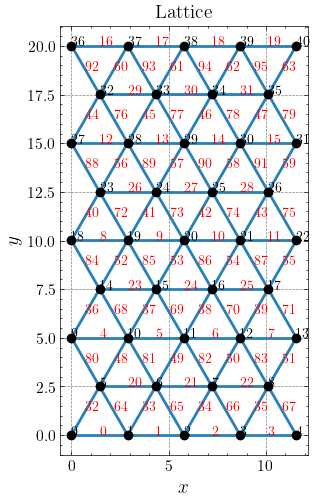

In [13]:
n1 = 4
n2 = 8

spacing = HTNI_y_pos[1, 0] - HTNI_y_pos[2, 0] # needs to be manually determined bc of inconsistent indexing
# spacing = 1.
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity = triangular_lattice_connectivity(n1=n1, n2=n2)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,
    young=jnp.ones(n_bonds),
    area=jnp.ones(n_bonds),
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.1*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
plot_lattice(lattice, annotate=True, figsize=(5, 5))

In [14]:
# Initial conditions
state0 = jnp.array([
    0*lattice.control_params.reference_points,  # Initial displacements
    0*lattice.control_params.reference_points,  # Initial velocities
])
timepoints = jnp.linspace(0, ts[-1], 500)


def control_params_fn(t, control_params: ControlParams):
    # NOTE: This will be replace by the experimental temperature-dependent behavior.
    return control_params._replace(
        young = jnp.ones(n_bonds)*HTNI_young_fit(T(t)),
        # young=control_params.young,
        thermal_strain = jnp.ones(n_bonds)*(HTNI_stretch(T(t))-1)*0.8
        # thermal_strain=control_params.thermal_strain*(t/timepoints[-1]),
    )


solve_dynamics, _ = setup_dynamic_solver(
    lattice=lattice,
    control_params_fn=control_params_fn,
    constrained_point_DOF_pairs=jnp.array([[0, 0], [0, 1], [1, 0], [1, 1], [2, 0], [
                                          2, 1], [3, 0], [3, 1], [4, 0], [4, 1]]),
    rigid_bodies_points=[jnp.arange(lattice.n_points-n1-1, lattice.n_points)],  # Last row is a rigid body
)
lattice.solution = solve_dynamics(state0, timepoints, lattice.control_params)

strain_fn = build_strain_fn(lattice.connectivity)


(<Figure size 500x500 with 2 Axes>,
 <Axes: title={'center': 'Final state'}, xlabel='$x$', ylabel='$y$'>)

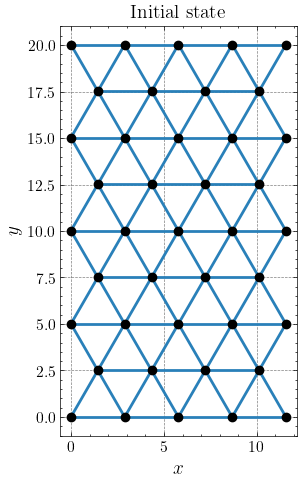

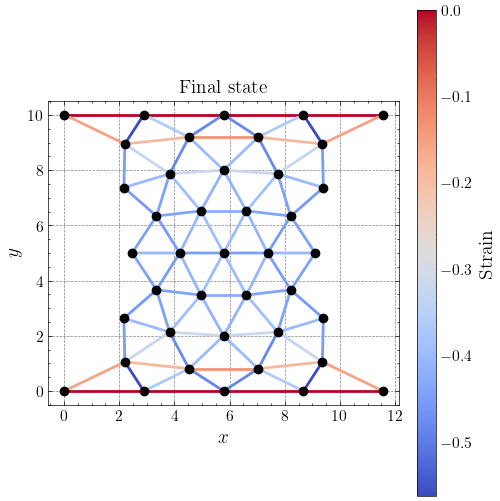

In [15]:
plot_lattice(lattice, lattice.solution[0, 0], title='Initial state', figsize=(3, 6))
plot_lattice(lattice, lattice.solution[-1, 0], title='Final state', figsize=(5, 5),
             bond_values=strain_fn(lattice.control_params.reference_points, lattice.solution[-1, 0]),
             label='Strain')


### HTNI Numerical and Experimental comparison

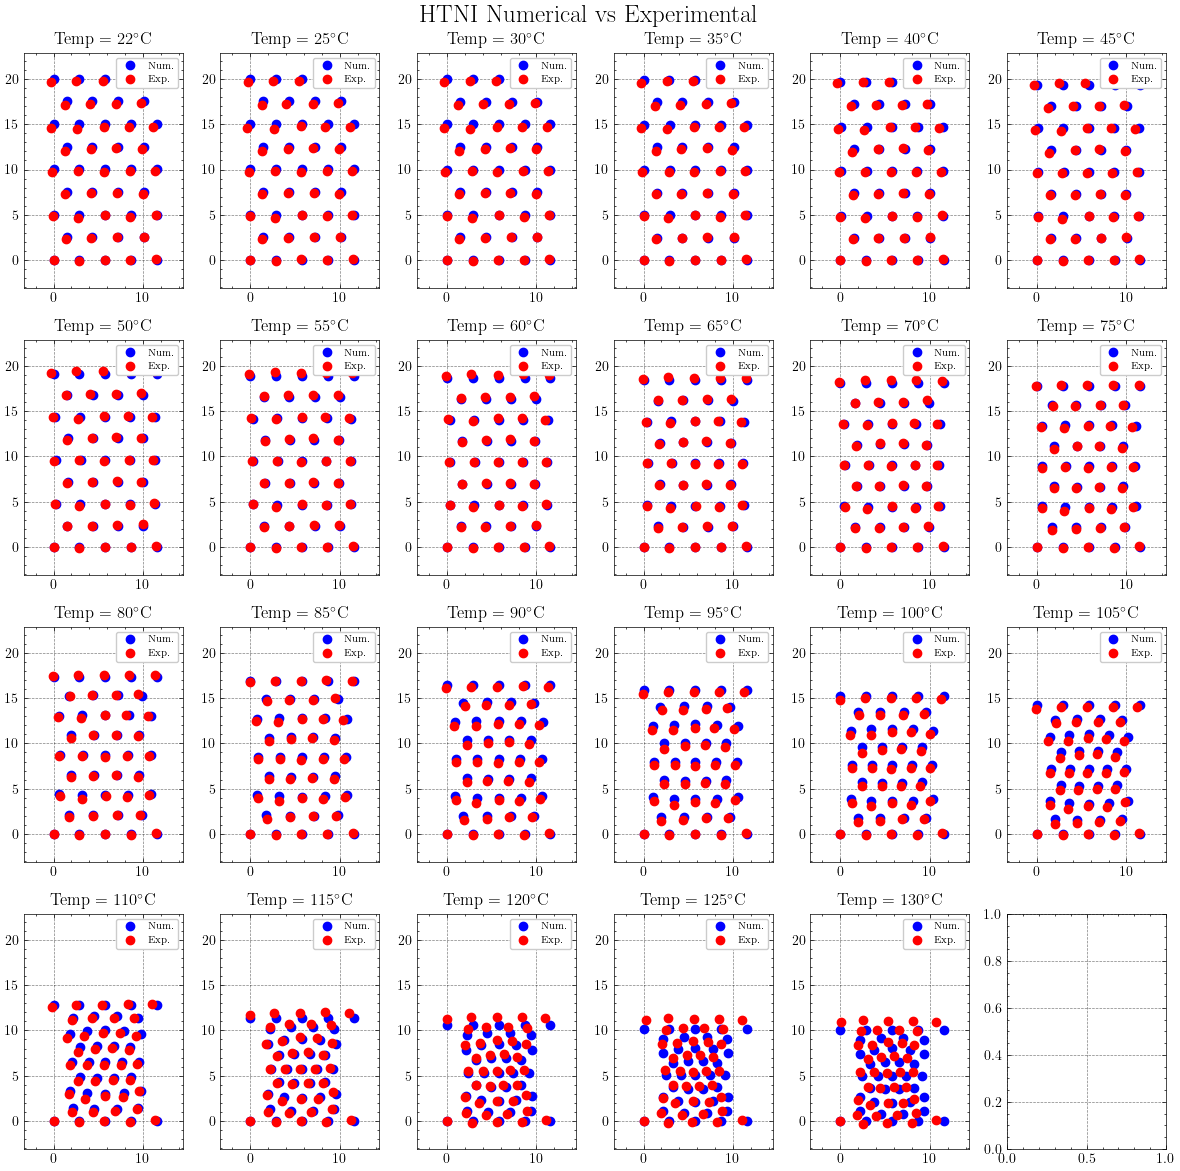

In [16]:
temp_evolution = T(timepoints) # temperature evolution over time used in numerical simulations

fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            ax[i, j].plot(points[:, 0]+lattice.solution[timepoint_near_temp_i, 0, :, 0], points[:, 1]+lattice.solution[timepoint_near_temp_i, 0, :, 1], 'bo', label='Num.')
            ax[i, j].plot(HTNI_y_pos[:, exp_idx_i], HTNI_x_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_xlim([min(HTNI_y_pos[:, 0]) - 3, max(HTNI_y_pos[:, 0]) + 3])
            ax[i, j].set_ylim([min(HTNI_x_pos[:, 0]) - 3, max(HTNI_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

            
plt.suptitle('HTNI Numerical vs Experimental', fontsize=18)
plt.tight_layout()

### LTNI Numerical and Experimental Comparison

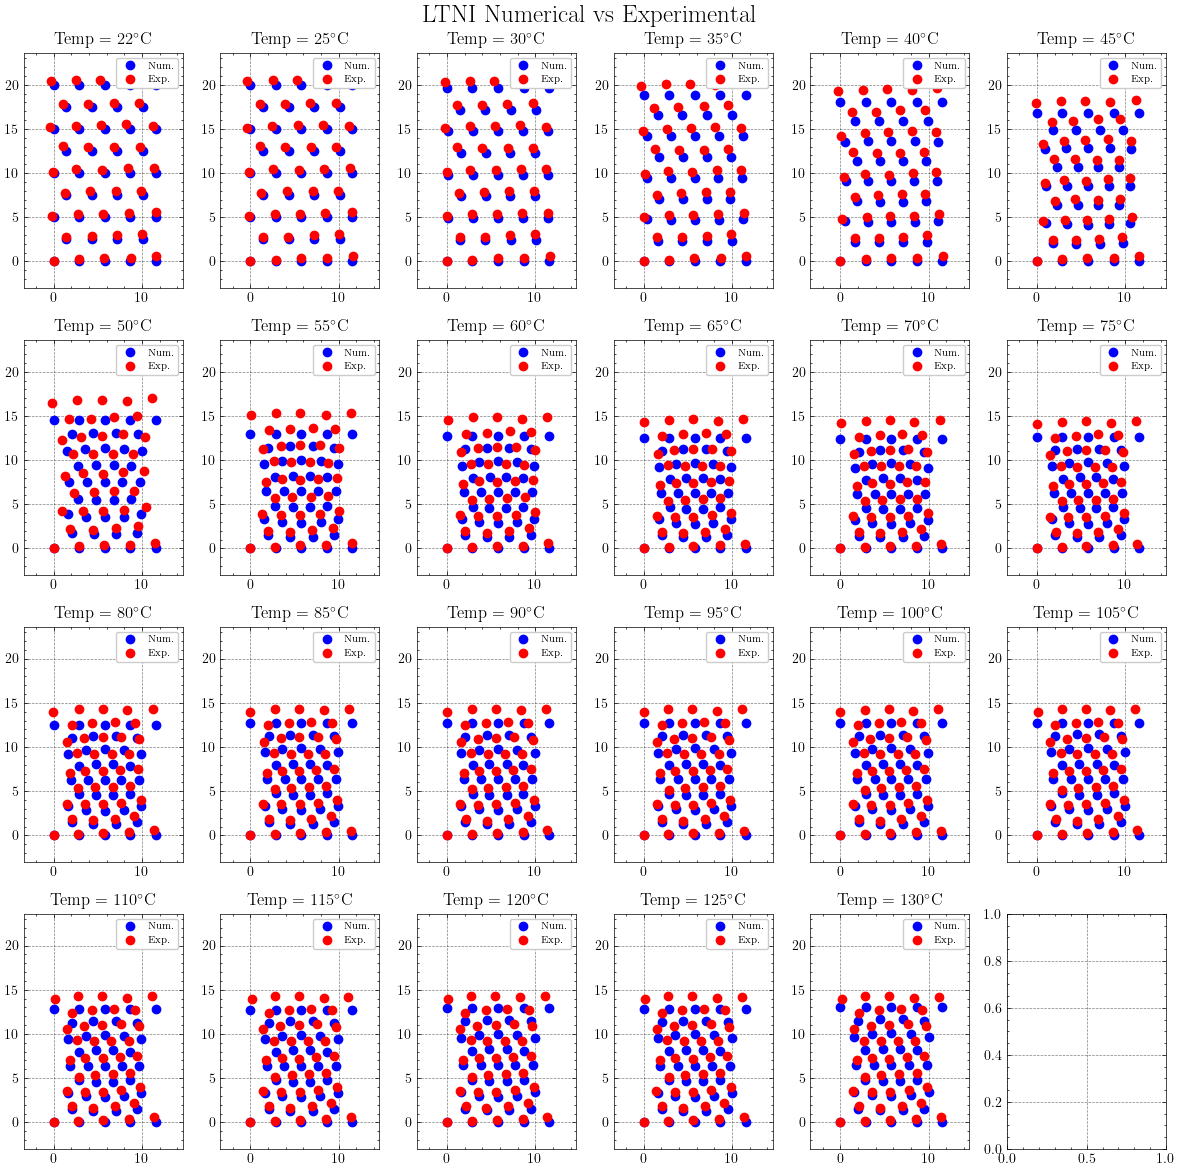

In [20]:
temp_evolution = T(timepoints) # temperature evolution over time used in numerical simulations

fig, ax = plt.subplots(4, 6, figsize = [12, 12])

counter = -1
for i in jnp.arange(ax.shape[0]):
    for j in jnp.arange(ax.shape[1]):
        counter+=1

        if counter < len(sampled_temps):
            temp_i = sampled_temps[counter]
            exp_idx_i = jnp.where(sampled_temps == temp_i)[0][0]
            timepoint_near_temp_i = jnp.argmin(abs(temp_evolution - temp_i))

            ax[i, j].plot(points[:, 0]+lattice.solution[timepoint_near_temp_i, 0, :, 0], points[:, 1]+lattice.solution[timepoint_near_temp_i, 0, :, 1], 'bo', label='Num.')
            ax[i, j].plot(LTNI_y_pos[:, exp_idx_i], LTNI_x_pos[:, exp_idx_i], 'ro', label='Exp.')
            ax[i, j].set_xlim([min(LTNI_y_pos[:, 0]) - 3, max(LTNI_y_pos[:, 0]) + 3])
            ax[i, j].set_ylim([min(LTNI_x_pos[:, 0]) - 3, max(LTNI_x_pos[:, 0]) + 3])
            ax[i, j].legend(fontsize=7, loc='upper right')
            ax[i, j].set_title(f'Temp = {temp_i}$^\circ$C')

plt.suptitle('LTNI Numerical vs Experimental', fontsize=18)
plt.tight_layout()